In [ ]:
!pip install pmdarima
from google.colab import output
output.clear()

In [ ]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.preprocessing import minmax_scale
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math


In [ ]:
# load stock data into pandas DataFrame
df = pd.read_csv('VIX Data - final.csv')
df = df.fillna(method='bfill')
df = df.drop(['Date'], axis = 1)
df = df[::-1]
df.index = df.index[::-1]
#df= df[:2500]
df = df[:-1]


In [ ]:
#Test for staionarity

def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)

    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
from pmdarima.arima import auto_arima
import torch
# Load the time series data
data = df['Volatility']
device = 'cuda'
# Define the train and test sets
train_size = int(len(data) * 0.9)
train_data, test_data = data[:train_size], data[train_size:]
# train_data_tensor = torch.Tensor([train_data]).to(device)



<Figure size 1000x600 with 0 Axes>

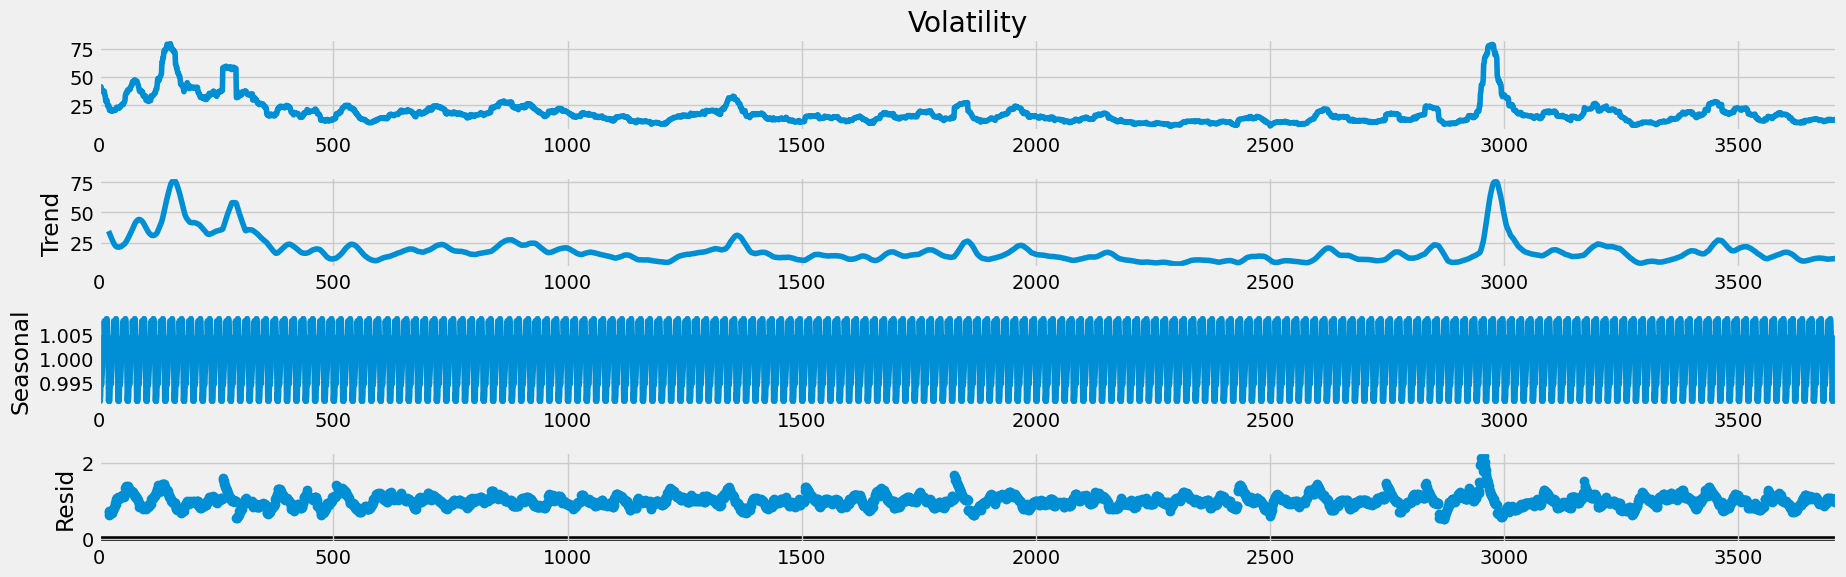

In [ ]:
result = sm.tsa.seasonal_decompose(data, model='multiplicative', period = 20, two_sided= 0)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(20, 6)

In [ ]:
model_auto = auto_arima(data, #exogenous = df_comp[['ret_spx', 'ret_dax', 'ret_nikkei']][1:],
                        m = 20,
                       max_order = None, max_p = 7, max_q = 7, max_d = 2, max_P = 4, max_Q = 4, max_D = 2,
                       maxiter = 50, alpha = 0.05, n_jobs = -1, trend = 'ct', information_criterion = 'oob',
                       out_of_sample = int(len(data)*0.2))

In [ ]:
model_auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 3711
Model:               SARIMAX(2, 1, 2)   Log Likelihood               -5517.470
Date:                Mon, 17 Apr 2023   AIC                          11048.940
Time:                        07:32:57   BIC                          11092.471
Sample:                             0   HQIC                         11064.429
                               - 3711                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0115      0.006     -1.964      0.050      -0.023   -2.46e-05
drift       4.012e-06   3.23e-06      1.242      0.214   -2.32e-06    1.03e-05
ar.L1          0.2463      0.095      2.584      0.010       0.060       0.433
ar.L2          0.6688      0.090      7.395      0.000       0.492       0.846
ma.L1         -0.2082      0.105     -1.975      0.048      -0.415      -0.002
ma.L2         -0.5726      0.090     -6.338      0.000      -0.750      -0.396
sigma2         1.1533      0.003    339.523      0.000       1.147       1.160
===================================================================================
Ljung-Box (L1) (Q):                   0.32   Jarque-Bera (JB):           3734322.98
Prob(Q):                              0.57   Prob(JB):                         0.00
Heteroskedasticity (H):               0.55   Skew:                            -2.34
Prob(H) (two-sided):                  0.00   Kurtosis:                       158.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
model_auto.plot_diagnostics(figsize=(15,8))

NameError: ignored

In [ ]:
# # Perform automated order selection using auto_arima
# auto_model = auto_arima(train_data,
#                          start_p=0,
#                          start_q=0,
#                       # test='adf',       # use adftest to find optimal 'd'
#                       max_p=3, max_q=3, # maximum p and q
#                       # m=20,              # frequency of series
#                       d=None,           # let model determine 'd'
#                       # seasonal=True,   # No Seasonality
#                       # start_P=0,
#                       # D=0,
#                       trace=True,
#                       # error_action='ignore',
#                       # suppress_warnings=True,
#                       # stepwise=True
#                       )

# # Print the model summary
# print(auto_model.summary())

In [ ]:
# auto_model.seasonal_order
model_auto.seasonal_order

(0, 0, 0, 20)

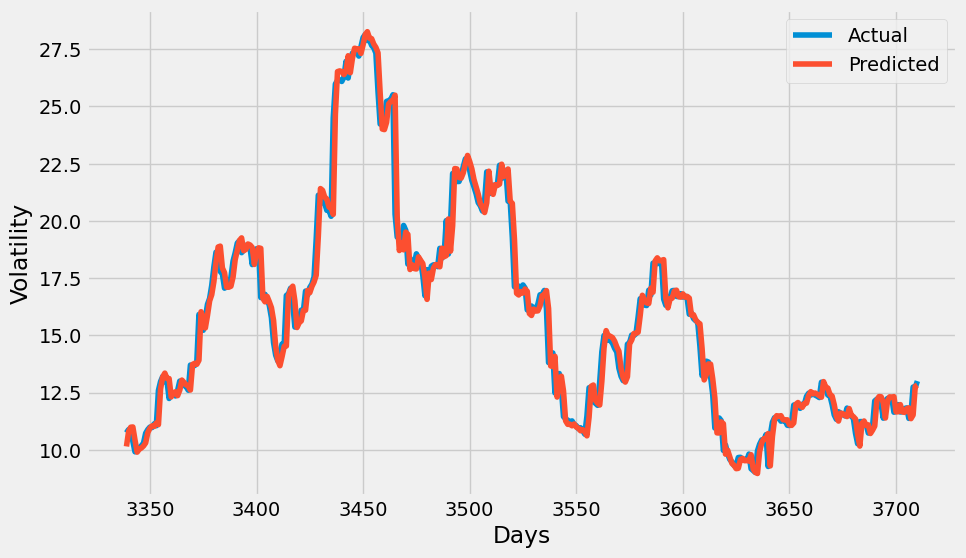

In [ ]:
# Fit the SARIMA model
sarima_model = SARIMAX(data, order=(2,1,2), seasonal_order=(0,0,0,20))
sarima_fit = sarima_model.fit()

# Forecast the test set
# forecast = sarima_fit.forecast(len(test_data))
forecast = sarima_fit.predict(start=train_size, end= train_size+len(test_data)-1)


# Plot the actual vs. predicted values
plt.plot(test_data.index, test_data.values, label='Actual')
plt.plot(test_data.index, forecast, label='Predicted')
plt.xlabel('Days')
plt.ylabel('Volatility')
plt.legend()
plt.show()

In [ ]:
mean_squared_error(test_data, forecast)

0.4803717846742886

In [ ]:
# # Load the time series and exogenous variables data
# data = df['Volatility']
# exog = df.drop(['Volatility'], axis = 1)

# model_ret_armax = SARIMAX(data, exog = exog, order = (1,0,1))
# results_ret_armax = model_ret_armax.fit()

# df_pred_armax = results_ret_armax.predict(test_data,
#                                           exog = exog.iloc[train_size:])

# df_pred_armax[start_date:end_date].plot(figsize = (20,5), color = "red")
# df_test.ret_ftse[start_date:end_date].plot(color = "blue")
# plt.title("Predictions vs Actual (Returns)", size = 24)
# plt.show()

In [ ]:
df

,Close,Volatility,Volume,Libor,US 10y Treasury yield,CBOE VIX,WTI Crude Oil Futures,Gold
0,4747.0498,40.89,101412896,2.71563,3.4807,912.74213,4436.46289,934.00
1,4733.0000,40.57,150143600,2.71000,3.5394,877.22180,4394.49023,928.80
2,4777.7998,40.75,132773104,2.71313,3.4694,937.69623,4402.29590,925.30
3,4879.6499,41.37,152074592,2.71594,3.6003,911.31390,4552.16895,927.90
4,4887.2998,41.29,137210800,2.73375,3.6886,820.27612,4592.02832,944.40
...,...,...,...,...,...,...,...,...
3706,16951.7000,11.37,238840912,5.16286,3.5696,1640.59546,6013.60000,1973.54
3707,17080.7000,11.56,345911072,5.15914,3.5639,1572.71558,6002.15000,1964.70
3708,17359.7500,12.74,263889040,5.19271,3.4676,1535.72815,6214.36000,1969.28
3709,17398.0500,12.72,230170688,5.22257,3.4114,1525.42212,6613.18000,1984.65


**SARIMAx** MODEL

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from statsmodels.tsa.stattools import adfuller

# Load the time series and exogenous variables data
data = df['Volatility']
exog = df.drop(['Volatility', 'WTI Crude Oil Futures', 'Gold'], axis = 1)

# Define the train and test sets
train_size = int(len(data) * 0.9)
train_data, test_data = data[:train_size], data[train_size:]
train_exog, test_exog = exog[:train_size], exog[train_size:]

# Check and transform the stationarity of the exogenous variables
def check_stationarity(exog):
    stationary_exog = pd.DataFrame()
    for col in exog.columns:
        adf_result = adfuller(exog[col])
        print(f'ADF Statistic ({col}): {adf_result[0]:.2f}')
        print(f'p-value ({col}): {adf_result[1]:.2f}')
        print(f'Critical Values ({col}): {adf_result[4]}')
        if adf_result[1] <= 0.05:
            print(f'{col} is stationary')
            stationary_exog[col] = exog[col].diff().fillna(exog[col].iloc[0])
        else:
            print(f'{col} is non-stationary')
            stationary_exog[col] = exog[col]
    return stationary_exog

from scipy.stats import yeojohnson

def make_stationary(exog):
    adf_result = adfuller(exog)
    print(f'ADF Statistic: {adf_result[0]:.2f}')
    print(f'p-value: {adf_result[1]:.2f}')
    print(f'Critical Values: {adf_result[4]}')
    if adf_result[1] <= 0.05:
        print('Stationary')
        return exog
    else:
        print('Non-stationary, applying Yeo-Johnson transformation')
        transformed_exog, lam = yeojohnson(exog)
        print(f'Lambda: {lam:.2f}')
        return transformed_exog

# train_exog_stationary = train_exog.apply(make_stationary)
# test_exog_stationary = test_exog.apply(make_stationary)



# Perform automated order selection using auto_arima
# auto_model = auto_arima(train_data, exogenous=train_exog_stationary, seasonal=True, m=12)

# Print the model summary
# print(auto_model.summary())



In [ ]:
model_auto = auto_arima(train_data, exogenous = train_exog,
                        m = 20,
                       max_order = None, max_p = 2, max_q = 2, max_d = 2, max_P = 4, max_Q = 4, max_D = 2,
                       maxiter = 50, alpha = 0.05, n_jobs = -1, trend = 'ct', information_criterion = 'oob',
                       out_of_sample = int(len(data)*0.2))

KeyboardInterrupt: ignored

In [ ]:
model_auto.summary()

# check_stationarity(train_exog_stationary)

In [ ]:
# Fit the SARIMAX model
sarimax_model = SARIMAX(data, exog=exog, order=(0,1,0), seasonal_order=(2,0,0,20))
sarimax_fit = sarimax_model.fit()

# Forecast the test set
forecast = sarimax_fit.predict(start=train_size, end= train_size+len(test_data)-1, exog=test_exog)




/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
pd.DataFrame(sarimax_fit.summary().tables[1])[[0,4]]

,0,4
0,,P>|z|
1,Close,0.000
2,Volume,0.000
3,Libor,0.000
4,US 10y Treasury yield,0.000
5,CBOE VIX,0.000
6,ar.S.L20,0.000
7,ar.S.L40,0.000
8,sigma2,0.000


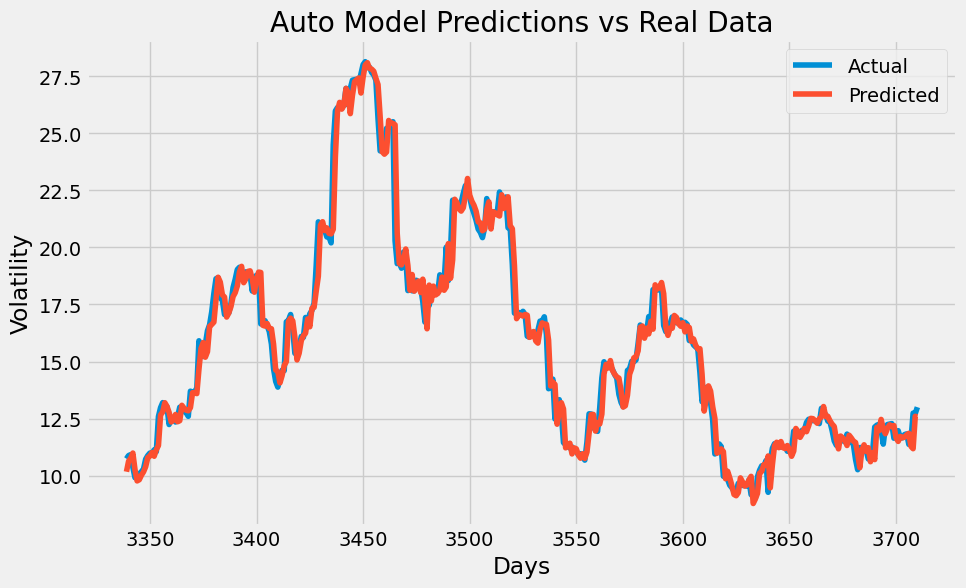

In [ ]:
# Plot the actual vs. predicted values
plt.plot(test_data.index, test_data.values, label='Actual')
plt.plot(test_data.index, forecast.values, label='Predicted')
plt.title("Auto Model Predictions vs Real Data")
plt.xlabel('Days')
plt.ylabel('Volatility')
plt.legend()
plt.show()


In [ ]:
test_mm, forecast_mm = minmax_scale(test_data.values), minmax_scale( forecast.values)

r2_score(test_data.values, forecast.values)
mean_squared_error(test_data.values, forecast.values)

0.4702680533823816

In [ ]:
mean_squared_error(test_mm, forecast_mm)

0.0013340672272477967

In [ ]:
r2_score(test_mm, forecast_mm )


0.9774093355227489

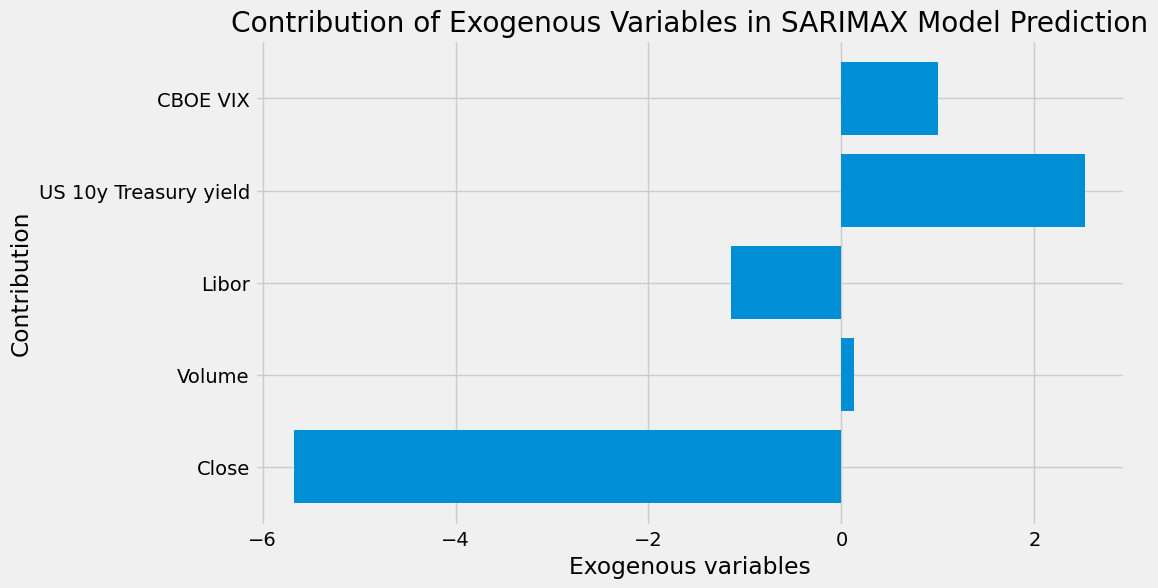

In [ ]:
# Calculate contribution of each exogenous variable
exog_contrib = sarimax_fit.params[:exog.shape[1]] * exog.mean()

# Create bar chart of exogenous variable contributions
plt.barh(width=exog_contrib,y=exog.columns)
plt.xlabel('Exogenous variables')
plt.ylabel('Contribution')
plt.title('Contribution of Exogenous Variables in SARIMAX Model Prediction')
plt.show()

In [ ]:
sarimax_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         Volatility   No. Observations:                 3711
Model:             SARIMAX(0, 1, 0)x(2, 0, 0, 20)   Log Likelihood               -5554.642
Date:                            Mon, 17 Apr 2023   AIC                          11125.285
Time:                                    08:30:22   BIC                          11175.035
Sample:                                         0   HQIC                         11142.988
                                           - 3711                                         
Covariance Type:                              opg                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Close                    -0.0006   5.04e-05    -12.619      0.000      -0.001      -0.001
Volume                  5.11e-10   1.07e-10      4.775      0.000    3.01e-10    7.21e-10
Libor                    -1.0942   1.97e-06  -5.56e+05      0.000      -1.094      -1.094
US 10y Treasury yield     1.0511   5.04e-06   2.08e+05      0.000       1.051       1.051
CBOE VIX                  0.0008   6.01e-05     13.398      0.000       0.001       0.001
ar.S.L20                 -0.0009   5.87e-05    -15.546      0.000      -0.001      -0.001
ar.S.L40                 -0.0358      0.000   -257.909      0.000      -0.036      -0.035
sigma2                    1.1568      0.003    381.040      0.000       1.151       1.163
===================================================================================
Ljung-Box (L1) (Q):                  12.25   Jarque-Bera (JB):           3627543.57
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.57   Skew:                            -2.09
Prob(H) (two-sided):                  0.00   Kurtosis:                       156.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.71e+22. Standard errors may be unstable.
"""

In [ ]:
!pip install arch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.5/920.5 kB 12.1 MB/s eta 0:00:00


In [ ]:
from arch import arch_model
# Calculate residuals
residuals = data.values - sarimax_fit.fittedvalues

# Fit GARCH model on residuals
garch_model = arch_model(residuals[1:], vol='GARCH', p=1, q=1)
garch_results = garch_model.fit()

# # Make volatility forecast
# target_index = data
garch_forecast = garch_results.forecast(horizon=1, start = train_size, align='target')

# # Combine stock price forecast and volatility forecast
# forecast_with_volatility = pd.concat([forecast, forecast_volatility.mean[train_size:]], axis=1)

# print(forecast_with_volatility)

Iteration:      1,   Func. Count:      6,   Neg. LLF: 17270.138256598653
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4020.7827931613247
Iteration:      3,   Func. Count:     20,   Neg. LLF: 3211.9970624325006
Iteration:      4,   Func. Count:     26,   Neg. LLF: 3091.4294007293106
Iteration:      5,   Func. Count:     31,   Neg. LLF: 11806.931764986435
Iteration:      6,   Func. Count:     40,   Neg. LLF: 4278.764450712806
Iteration:      7,   Func. Count:     46,   Neg. LLF: 991593.4221823046
Iteration:      8,   Func. Count:     54,   Neg. LLF: 3066.6483012159147
Iteration:      9,   Func. Count:     59,   Neg. LLF: 3066.167864823463
Iteration:     10,   Func. Count:     64,   Neg. LLF: 3066.0710022642743
Iteration:     11,   Func. Count:     69,   Neg. LLF: 3066.0672395716483
Iteration:     12,   Func. Count:     74,   Neg. LLF: 3066.067103238844
Iteration:     13,   Func. Count:     79,   Neg. LLF: 3066.0671535434794
Iteration:     14,   Func. Count:     84,   Neg. LLF: 3

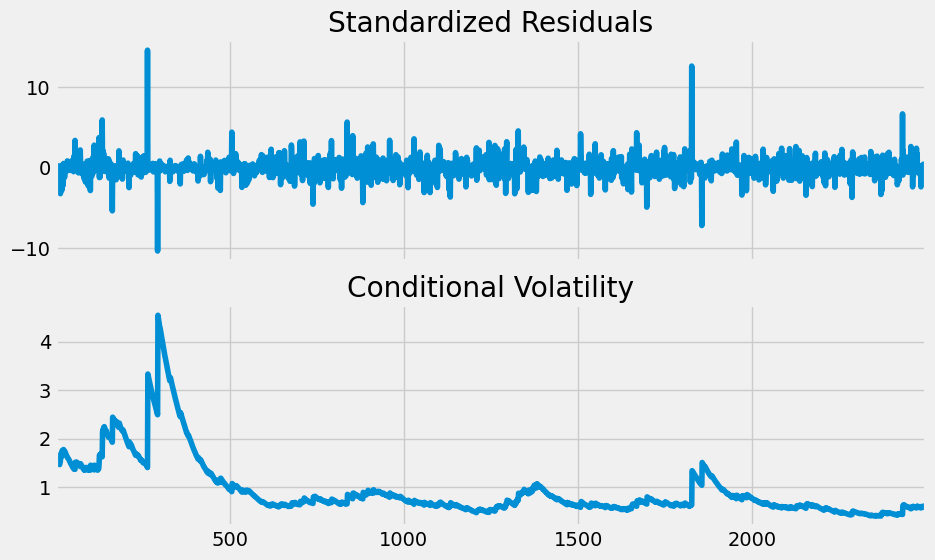

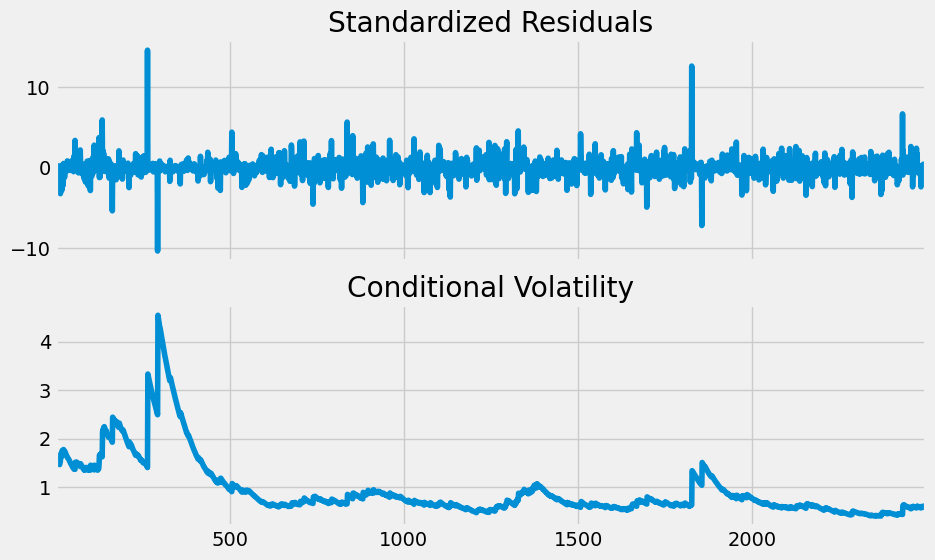

In [ ]:
garch_results.plot()

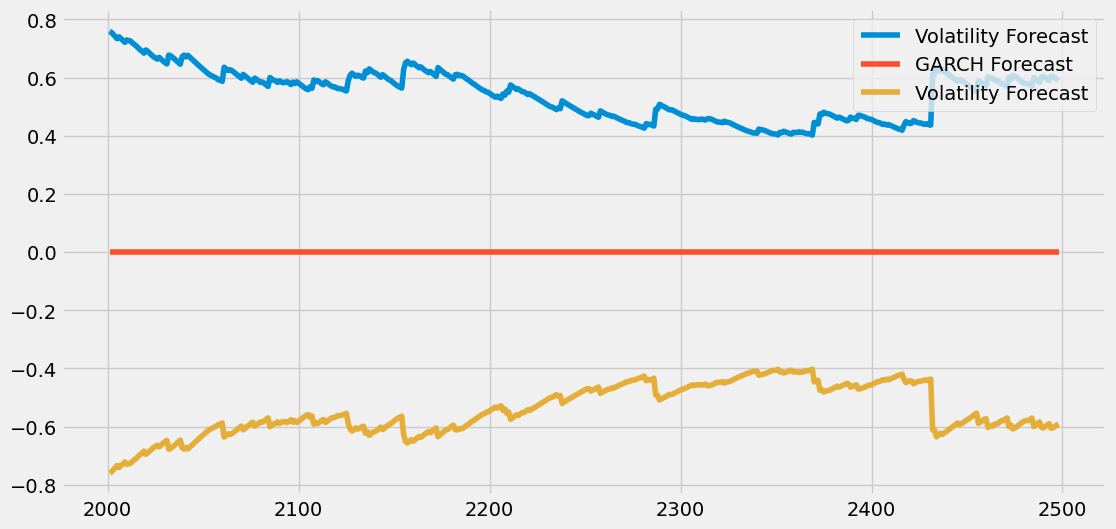

In [ ]:
# Plot SARIMAX and GARCH results and forecasts
fig, ax = plt.subplots(figsize=(12,6))
#ax.plot(data.index, data, label='Observed')
#ax.plot(forecast.index, forecast, label='SARIMAX Forecast')

gh_mu =  garch_forecast.mean
gh_std = np.sqrt(garch_forecast.residual_variance)
ax.plot(garch_forecast.mean.index, gh_mu + gh_std, label='Volatility Forecast')
ax.plot(garch_forecast.residual_variance.index, gh_mu, label='GARCH Forecast')
ax.plot(garch_forecast.residual_variance.index, gh_mu - gh_std, label='Volatility Forecast')
ax.legend()
plt.show()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 5084966432.460683
Iteration:      2,   Func. Count:     13,   Neg. LLF: 918157443.1400696
Iteration:      3,   Func. Count:     19,   Neg. LLF: 11610.022638038925
Iteration:      4,   Func. Count:     25,   Neg. LLF: 10173.028871063958
Iteration:      5,   Func. Count:     31,   Neg. LLF: 7574.286452580286
Iteration:      6,   Func. Count:     37,   Neg. LLF: 7572.123366675599
Iteration:      7,   Func. Count:     43,   Neg. LLF: 7770.914596826309
Iteration:      8,   Func. Count:     49,   Neg. LLF: 7578.502327508689
Iteration:      9,   Func. Count:     55,   Neg. LLF: 7660.065567751866
Iteration:     10,   Func. Count:     61,   Neg. LLF: 7235.608060760573
Iteration:     11,   Func. Count:     67,   Neg. LLF: 7363.140551388002
Iteration:     12,   Func. Count:     73,   Neg. LLF: 8379.862745944467
Iteration:     13,   Func. Count:     79,   Neg. LLF: 7490.560704990285
Iteration:     14,   Func. Count:     85,   Neg. LLF: 7985.263

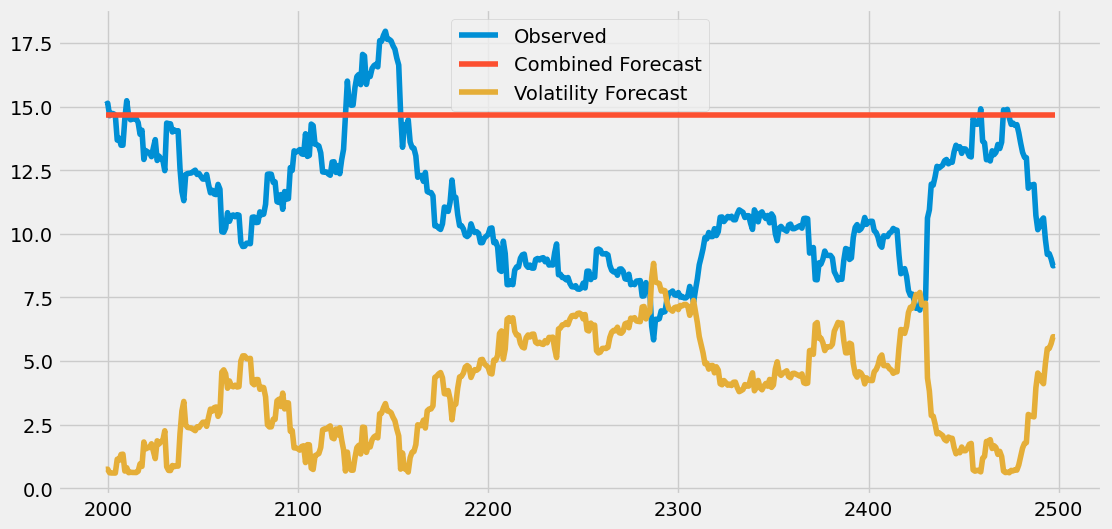

In [ ]:
# Combine ARIMA and GARCH models
combined_model = arch_model(y=data, x=sarimax_fit.predict(), vol='GARCH', p=1, q=1)
combined_results = combined_model.fit()

# Generate forecast for next 10 time steps
forecast_horizon = 1
combined_forecast = combined_results.forecast(horizon=forecast_horizon, start = train_size)

# Plot ARIMA-GARCH forecast
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(data.index[train_size:], data[train_size:], label='Observed')
ax.plot(combined_forecast.mean.index, combined_forecast.mean, label='Combined Forecast')
ax.plot(combined_forecast.residual_variance.index, np.sqrt(combined_forecast.residual_variance), label='Volatility Forecast')
ax.legend()
plt.show()

GARCH MODEL

In [ ]:
from arch import arch_model

mod_garch = arch_model(data, vol = "GARCH", p = 1, q = 1, dist = "skewt", mean='HAR', x=exog)
res_garch = mod_garch.fit(last_obs = train_size, update_freq = 10)

Iteration:     10,   Func. Count:     83,   Neg. LLF: 27398.50058662
Iteration:     20,   Func. Count:    163,   Neg. LLF: 5130.463901613462
Iteration:     30,   Func. Count:    236,   Neg. LLF: 5126.129642190073
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5126.1210573139315
            Iterations: 37
            Function evaluations: 271
            Gradient evaluations: 35


In [ ]:
# res_garch.summary()
res_garch.params

Const       13.352445
omega        1.366901
alpha[1]     0.993798
beta[1]      0.006202
eta          6.206164
lambda      -0.800847
Name: params, dtype: float64

In [ ]:
test_exog

,Close,Volume,Libor,US 10y Treasury yield,CBOE VIX,WTI Crude Oil Futures,Gold
1999,7848.85,220712496,0.62660,1.7367,977.49463,3076.21362,1277.21
2000,7900.40,157444912,0.62610,1.7516,961.04614,3114.56299,1263.68
2001,7814.90,185061776,0.62760,1.7001,1008.04846,3097.20215,1273.45
2002,7860.75,211547776,0.62610,1.7533,980.57556,3187.53857,1274.16
2003,7890.75,189140816,0.62510,1.7723,1039.82373,3226.32544,1278.95
...,...,...,...,...,...,...,...
2494,10741.70,222115648,2.35575,3.0042,904.34027,4793.95000,1312.72
2495,10716.55,197988480,2.35500,2.9622,886.97229,4784.15000,1321.60
2496,10806.50,209392112,2.34250,2.9695,852.10779,4762.37000,1319.30
2497,10806.60,176697504,2.33000,3.0024,873.82880,4795.58000,1313.50


In [ ]:
# pred_garch = res_garch.forecast(horizon = 1, align='target')
# pred_garch.summary()

target_index = data
# forecast_target = res_garch.forecast(horizon=1, align='target', start=target_index[train_size])
# print(forecast_target.mean.iloc[-1])

pred_garch = res_garch.forecast(horizon=1, start=train_size, align='target')
pred_garch.residual_variance[train_size:]

,h.1
1999,NaN
2000,4.372142
2001,4.534124
2002,3.042539
2003,3.271660
...,...
2494,14.104965
2495,18.672870
2496,18.453898
2497,20.135017


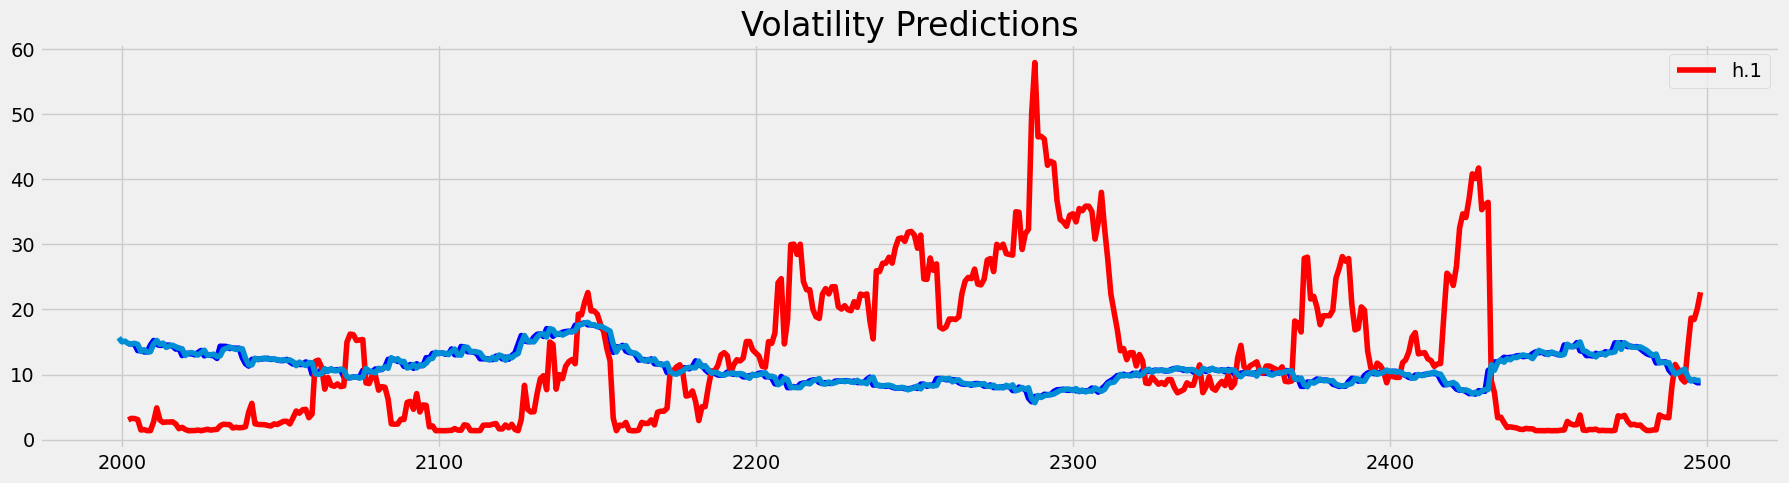

In [ ]:

pred_garch.residual_variance[train_size+3:].plot(figsize = (20,5), color = "red", zorder = 2)
plt.plot(forecast)
test_data[3:].abs().plot(color = "blue", zorder = 1)
plt.title("Volatility Predictions", size = 24)
plt.show()

In [ ]:
r2_score(pred_garch.residual_variance, data)

ValueError: ignored

In [ ]:
pred_garch.residual_variance[train_size:]

,h.1
1999,NaN
2000,4.372142
2001,4.534124
2002,3.042539
2003,3.271660
...,...
2494,14.104965
2495,18.672870
2496,18.453898
2497,20.135017
